data: http://opus.nlpl.eu/download.php?f=OpenSubtitles/v2018/mono/OpenSubtitles.raw.es.gz (2Gb)

In [1]:
import random
import re
import numpy as np
import matplotlib.pyplot as plt

In [2]:
corpus_name = "OpenSubtitle_UNK"
corpus = "../data/es.txt"

def printLines(file, stop=10):
    with open(file, 'rb') as datafile:
        for i,line in enumerate(datafile):
            print(line)#.decode("utf-8"))
            if i==stop: break

printLines(corpus,10)

b'NETKonet trae para ti...\n'
b'"Twenty"\n'
b'[NEW Presenta]\n'
b'[Una producci\xc3\xb3n de A M Tree Pictures]\n'
b'[Sidus HQ]\n'
b'[Productor ejecutivo:\n'
b'Kim Woo Taek]\n'
b'Somos los t\xc3\xadpicos amigos de la secundaria que juraron que su amistad durar\xc3\xada para siempre.\n'
b'Aunque las circunstancias del inicio de nuestra amistad no fueron especiales en cierto modo fueron especiales para nosotros.\n'
b'Ejem... ejem.\n'
b'Ejem...\n'


In [3]:
#lineas totales: 213_517_354
MAX_LENGTH=20

def processLine(l):
    s = l.lstrip(b"-").strip().lower().decode() #elimina guion del principio de algunas lineas
    s = re.sub(r"([.!?])", r" \1", s) #separa puntuacion
    s = re.sub(r"([.¡¿])", r"\1 ", s) #separa puntuacion
    s = re.sub(r"[,]",r"",s) #quita las comas
    return s


def loadLines(file, total_lines=10, max_lenght=MAX_LENGTH):
    with open(file, 'rb') as datafile:
        n=0
        for i,line in enumerate(datafile):
            if max(line.find(b"["),line.find(b"]")) == -1: #filtra los comentarios
                s = processLine(line)
                if len(s.split(' ')) < max_lenght: #filtra frases largas
                    n+=1
                    yield i,s
            if n==total_lines: break
                
for i,l in loadLines(corpus,100):
    print(i,l)

0 netkonet trae para ti .  .  . 
1 "twenty"
7 somos los típicos amigos de la secundaria que juraron que su amistad duraría para siempre . 
9 ejem .  .  .  ejem . 
10 ejem .  .  . 
12 ¿ le acariciaste el pecho a fo min ?
13 no . 
14 no se lo acaricié me quede allí parado tocándolo . 
15 debes estar demente . 
16 ¿ eso es una pregunta ?
17 ¿ crees que fue una pregunta idiota ?
18 ey que ya no somos niños . 
19 ¿ en qué estaban pensando para pelear así por una chica ?
20 deben resolverlo de forma razonable . 
21 háganlo con piedra papel o tijeras . 
22 es una buena idea .  ¡ hagámoslo !
23 ok solo haremos una ronda como hombres . 
24 ¡ piedra papel o tijeras !
25 un hombre de verdad usa una piedra . 
26 ¡ piedra papel o tijeras !
27 hagámoslo de nuevo . 
28 piedra papel o tijeras . 
29 piedra papel o tijeras . 
30 piedra papel o tijeras . 
31 piedra papel o tijeras . 
32 yo saldré con ella primero . 
33 ya que gané en piedra papel o tijeras y ya le toqué el pecho . 
34 vamos ni que nuestr

In [5]:
#lineas usadas sobre el total
f"{500_000/213_517_354:.3%}"

'0.234%'

In [6]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token
UNK_token = 3  
class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {"UNK": UNK_token}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS", UNK_token:"UNK"}
        self.num_words = 4  # Count SOS, EOS, PAD, UNK

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print(f"keep_words {len(keep_words)} / { len(self.word2index)} = "
              f"{len(keep_words) / len(self.word2index):.4f}")

        # Reinitialize dictionaries
        self.word2index = {"UNK": UNK_token}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS", UNK_token:"UNK"}
        self.num_words = 4 # Count default tokens

        for word in keep_words:
            self.addWord(word)

56762


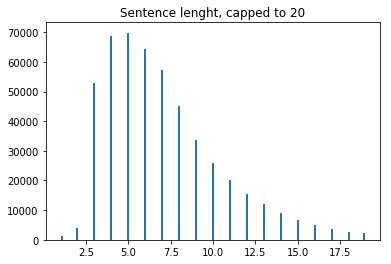

In [7]:
voc = Voc(corpus_name)

hist = []  
for i,s in loadLines(corpus,500_000):
    s_l = len(s.split(' '))
    hist.append(s_l)
    voc.addSentence(s)
    
print(voc.num_words)

arr = np.array(hist)
plt.hist(arr, bins='auto')  # arguments are passed to np.histogram
plt.title(f"Sentence lenght, capped to {MAX_LENGTH}")
plt.show()

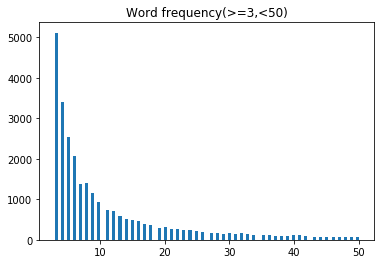

In [8]:
hist=[]
for i,n in enumerate(voc.word2count):
    c = voc.word2count[n]
    if c>=3:
        hist.append(c)
        
arr = np.array(hist)
plt.hist(arr, bins=100,range=(3,50))  # arguments are passed to np.histogram
plt.title(f"Word frequency(>=3,<50)")
plt.show()

In [9]:
MIN_COUNT = 3    # Minimum word count threshold for trimming
voc.trim(MIN_COUNT)

keep_words 30611 / 56759 = 0.5393


In [10]:
# Filter out sentences with trimmed words
def contain_unk(sentence):
    for word in sentence.split(' '):
        if word not in voc.word2index:
            return True

In [11]:
total = 0
trimmed = 0
for i,s in loadLines(corpus,500_000):
    total += 1
    if contain_unk(s): trimmed +=1
        
print(f"{trimmed} lines contain trimmed words, {trimmed / total:.2%} of total")

30496 lines contain trimmed words, 6.10% of total


In [12]:
# Swap word not in voc for UNK
def swap_unk(sentence):
    words = sentence.split(" ")
    for i,word in enumerate(words):
        if word not in voc.word2index:
            words[i] = "UNK"
    return " ".join(words)

In [13]:
def gen_pairs(how_many):
    first_inpt = True
    n=0
    for out_idx,out_snt in loadLines(corpus,500_000):
        if first_inpt:
            inp_idx, inp_snt = out_idx,out_snt
            first_inpt = False
            continue

        if inp_idx+1 == out_idx: #frases contiguas
            if not contain_unk(out_snt):#input can contain unk, out cannot
                n+=1
                yield [swap_unk(inp_snt),out_snt]
            
        if n==how_many:break
        inp_idx, inp_snt = out_idx,out_snt
        
for pair in gen_pairs(1000):
    print(pair)

['ejem .  .  .  ejem . ', 'ejem .  .  . ']
['¿ le UNK el pecho a UNK min ?', 'no . ']
['no se lo UNK me quede allí parado UNK . ', 'debes estar demente . ']
['debes estar demente . ', '¿ eso es una pregunta ?']
['¿ eso es una pregunta ?', '¿ crees que fue una pregunta idiota ?']
['¿ crees que fue una pregunta idiota ?', 'ey que ya no somos niños . ']
['ey que ya no somos niños . ', '¿ en qué estaban pensando para pelear así por una chica ?']
['¿ en qué estaban pensando para pelear así por una chica ?', 'deben resolverlo de forma razonable . ']
['deben resolverlo de forma razonable . ', 'háganlo con piedra papel o tijeras . ']
['háganlo con piedra papel o tijeras . ', 'es una buena idea .  ¡ hagámoslo !']
['es una buena idea .  ¡ hagámoslo !', 'ok solo haremos una ronda como hombres . ']
['ok solo haremos una ronda como hombres . ', '¡ piedra papel o tijeras !']
['¡ piedra papel o tijeras !', 'un hombre de verdad usa una piedra . ']
['un hombre de verdad usa una piedra . ', '¡ piedra pa

['¿ por qué me hablas tan UNK ?', 'tenemos la misma edad así que deja las formalidades cuando estamos solos . ']
['tenemos la misma edad así que deja las formalidades cuando estamos solos . ', '¡ eun hye !']
['¡ eun hye !', '¡ nos preparamos para filmar !']
['¡ nos preparamos para filmar !', '¡ de prisa !']
['¡ de prisa !', '¡ sí director jo !']
['quiero UNK la cara . ', '¡ deja de moverte cuando te pego !']
['¡ deja de moverte cuando te pego !', '¡ corte !']
['¡ corte !', '¡ buen trabajo todos !']
['¡ buen trabajo todos !', '¿ estás bien ?']
['¿ estás bien ?', '¡ buen trabajo !']
['¡ buen trabajo !', '¿ estás bien ?']
['¿ estás bien ?', 'sí . ']
['sí . ', 'pueden golpearme tan duro como gusten . ']
['pueden golpearme tan duro como gusten . ', 'bien hagamos otra toma . ']
['bien hagamos otra toma . ', 'pónganse en posición todos . ']
['pónganse en posición todos . ', 'hagamos esta toma . ']
['hagamos esta toma . ', 'listos .  .  . ']
['listos .  .  . ', '¡ acción !']
['¡ acción !', '¡ 